In [20]:
'''Permanent link
https://huggingface.co/spaces/nnsohamnn/foodmodel'''

'Permanent link\nhttps://huggingface.co/spaces/nnsohamnn/foodmodel'

In [6]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import os
import urllib.request
import zipfile
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import shutil

In [2]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download...")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [3]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
selected_classes = ['chicken_curry', 'fried_rice', 'ice_cream', 'pizza', 'samosa']
root_dir = './data'

food101_dataset = datasets.Food101(root=root_dir, download=True)

100%|██████████| 5.00G/5.00G [03:42<00:00, 22.5MB/s]


Extracting ./data/food-101.tar.gz to ./data


In [7]:
selected_data_dir = './data/selected_classes'
os.makedirs(selected_data_dir, exist_ok=True)


food101_path = os.path.join(root_dir, 'food-101', 'images')

for class_name in selected_classes:
    src_dir = os.path.join(food101_path, class_name)
    dst_dir = os.path.join(selected_data_dir, class_name)
    shutil.copytree(src_dir, dst_dir)

print(f'Selected classes have been copied to {selected_data_dir}')

Selected classes have been copied to ./data/selected_classes


In [8]:

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


selected_dataset = datasets.ImageFolder(root=selected_data_dir, transform=transform)


train_size = int(0.8 * len(selected_dataset))
test_size = len(selected_dataset) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(selected_dataset, [train_size, test_size])


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f'Training and validation data loaders are ready.')


Training and validation data loaders are ready.


In [12]:
model = torchvision.models.mobilenet_v2(pretrained=True)
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [13]:
loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)
from helper_functions import accuracy_fn

In [14]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
epochs = 10

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}\n-----")
    train_loss = 0
    model.train()

    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)


        y_pred = model(X)
        loss = loss_fn(y_pred, y)


        train_loss += loss.item()


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_loader)

    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)


            test_pred = model(X_test)


            test_loss += loss_fn(test_pred, y_test).item()
            test_acc += accuracy_fn(y_test, test_pred.argmax(dim=1))


    test_loss /= len(test_loader)
    test_acc /= len(test_loader)

    print(f"Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")


Epoch: 1
-----
Train loss: 1.67925 | Test loss: 0.44589 | Test acc: 88.18
Epoch: 2
-----
Train loss: 0.25427 | Test loss: 0.35794 | Test acc: 90.33
Epoch: 3
-----
Train loss: 0.12114 | Test loss: 0.31688 | Test acc: 90.92
Epoch: 4
-----
Train loss: 0.07372 | Test loss: 0.30854 | Test acc: 91.99
Epoch: 5
-----
Train loss: 0.05114 | Test loss: 0.29938 | Test acc: 91.99
Epoch: 6
-----
Train loss: 0.03655 | Test loss: 0.32580 | Test acc: 91.11
Epoch: 7
-----
Train loss: 0.02936 | Test loss: 0.30643 | Test acc: 92.29
Epoch: 8
-----
Train loss: 0.02742 | Test loss: 0.30892 | Test acc: 91.80
Epoch: 9
-----
Train loss: 0.01369 | Test loss: 0.30814 | Test acc: 92.19
Epoch: 10
-----
Train loss: 0.01192 | Test loss: 0.31279 | Test acc: 92.09


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

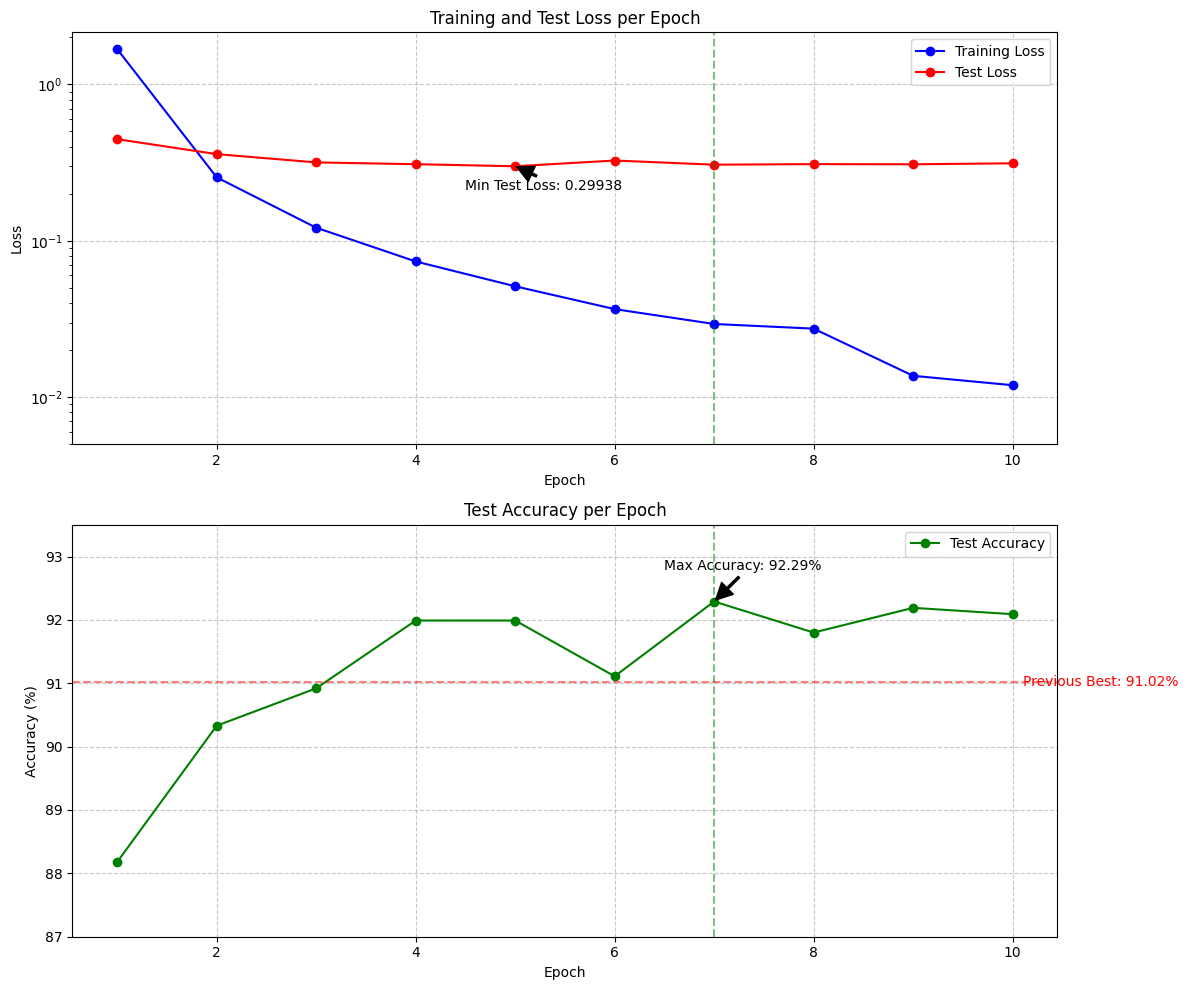

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Data from the improved training results
epochs = np.arange(1, 11)
train_loss = [1.67925, 0.25427, 0.12114, 0.07372, 0.05114, 0.03655, 0.02936, 0.02742, 0.01369, 0.01192]
test_loss = [0.44589, 0.35794, 0.31688, 0.30854, 0.29938, 0.32580, 0.30643, 0.30892, 0.30814, 0.31279]
test_acc = [88.18, 90.33, 90.92, 91.99, 91.99, 91.11, 92.29, 91.80, 92.19, 92.09]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# Plot the losses
ax1.plot(epochs, train_loss, 'b-o', label='Training Loss')
ax1.plot(epochs, test_loss, 'r-o', label='Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss per Epoch')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# Use log scale for y-axis since training loss drops dramatically
ax1.set_yscale('log')
ax1.set_ylim(bottom=0.005)  # Set minimum y value for better visualization

# Annotate the minimum test loss
min_test_loss_idx = np.argmin(test_loss)
ax1.annotate(f'Min Test Loss: {test_loss[min_test_loss_idx]:.5f}',
            xy=(epochs[min_test_loss_idx], test_loss[min_test_loss_idx]),
            xytext=(epochs[min_test_loss_idx]-0.5, test_loss[min_test_loss_idx]*0.7),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
            fontsize=10)

# Plot the test accuracy
ax2.plot(epochs, test_acc, 'g-o', label='Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Test Accuracy per Epoch')
ax2.set_ylim([87, 93.5])  # Set a reasonable range for better visualization
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.7)

# Annotate the maximum test accuracy
max_acc_idx = np.argmax(test_acc)
ax2.annotate(f'Max Accuracy: {test_acc[max_acc_idx]:.2f}%',
            xy=(epochs[max_acc_idx], test_acc[max_acc_idx]),
            xytext=(epochs[max_acc_idx]-0.5, test_acc[max_acc_idx]+0.5),
            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5),
            fontsize=10)

# Mark the epoch with best accuracy
ax2.axvline(x=epochs[max_acc_idx], color='g', linestyle='--', alpha=0.5)
ax1.axvline(x=epochs[max_acc_idx], color='g', linestyle='--', alpha=0.5)

# Add a horizontal line showing the previous best accuracy
ax2.axhline(y=91.02, color='r', linestyle='--', alpha=0.5)
ax2.text(10.1, 91.02, 'Previous Best: 91.02%', verticalalignment='center', color='r')

plt.tight_layout()
plt.savefig('improved_food_classification_results.png')
from google.colab import files
files.download('original_food_classification_results.png')
plt.show()

In [19]:
torch.save(model.state_dict(), 'model_state_dict.pth')